# Shapelets and the Shapelet Transform with sktime

Introduced in [1], **a shapelet is a time series subsequence** that is identified as being representative of class membership. 

Shapelets are a powerful approach for measuring _phase-independent_ similarity between time series; they can occur at any point within a series and offer _interpretable_ results for how matches occur. The original research extracted shapelets to build a decision tree classifier. 

The example below illustrates how leaf shape can be represented as a one-dimensional time series (blue line) to distinguish between two species.[2]

<img src = "img/leaf_types.png">
<img src = "img/verdena_shapelet.png">

The highlighted red subsection of the time series (i.e., "subsequences") above is the shapelet that distinguishes *Verbena urticifolia* from *Urtica dioica*.

## The Shapelet Transform

Much research emphasis has been placed on shapelet-based approaches for time series classification (TSC) since the original research was proposed. The current state-of-the-art for shapelets is the **shapelet transform** (ST) [3, 4]. The transform improves upon the original use of shapelets by **separating shapelet extraction from the classification algorithm**, allowing interpretable phase-independent classification of time series with any standard classification algorithm (such as random/rotation forest, neural networks, nearest neighbour classifications, ensembles of all, etc.). 

To facilitate this, rather than recursively assessing data for the best shapelet, the transform evaluates candidate shapelets in a single procedure to rank them based on information gain. Then, given a set of _k_ shapelets, a time series can be transformed into _k_ features by calculating the distance from the series to each shapelet. By transforming a dataset in this manner any vector-based classification algorithm can be applied to a shapelet-transformed time series problem while the interpretability of shapelets is maintained through the ranked list of the _best_ shapelets during transformation. 

Shapelets can provide interpretable results, as seen in the figure below:

<img src = "img/leaves_shapelets.png">

The shapelet has "discovered" where the two plant species distinctly differ. *Urtica dioica* has a stem that connects to the leaf at almost 90 degrees, whereas the stem of *Verbena urticifolia* connects to the leaf at a wider angle. 

Having found shapelet, its distance to the nearest matching subsequence in all objects in the database can be recorded. Finally, a simple decision tree classifier can be built to determine whether an object $Q$ has a subsequence within a certain distance from shapelet $I$.

<img src = "img/shapelet_classifier.png">

#### References
[1] Ye, Lexiang, and Eamonn Keogh. "Time series shapelets: a novel technique that allows accurate, interpretable and fast classification." Data mining and knowledge discovery 22, no. 1-2 (2011): 149-182.

[2] Ye, Lexiang, and Eamonn Keogh. "Time series shapelets: a new primitive for data mining." In Proceedings of the 15th ACM SIGKDD international conference on Knowledge discovery and data mining, pp. 947-956. 2009.

[3] Lines, Jason, Luke M. Davis, Jon Hills, and Anthony Bagnall. "A shapelet transform for time series classification." In Proceedings of the 18th ACM SIGKDD international conference on Knowledge discovery and data mining, pp. 289-297. ACM, 2012.

[4] Hills, Jon, Jason Lines, Edgaras Baranauskas, James Mapp, and Anthony Bagnall. "Classification of time series by shapelet transformation." Data Mining and Knowledge Discovery 28, no. 4 (2014): 851-881.

[5] Bostrom, Aaron, and Anthony Bagnall. "Binary shapelet transform for multiclass time series classification." In Transactions on Large-Scale Data-and Knowledge-Centered Systems XXXII, pp. 24-46. Springer, Berlin, Heidelberg, 2017.

## Methodology Summary

- Identify the best shapelets ranked on information gain
- Examine time series and calcualte distance from time series to each shapelet
- These distances are used as features in the classification problem
- Use almost any classification model
- Best shapelets can help with interpretability

## Example: The Shapelet Transform in sktime

The following workbook demonstrates a full workflow of using the shapelet transform in `sktime` with a `scikit-learn` classifier with the [OSU Leaf](http://www.timeseriesclassification.com/description.php?Dataset=OSULeaf) dataset, which consists of one dimensional outlines of six leaf classes: *Acer Circinatum*, *Acer Glabrum*, *Acer Macrophyllum*, *Acer Negundo*, *Quercus Garryana* and *Quercus Kelloggii*.

In [1]:
from sktime.datasets import load_osuleaf
from sktime.transformations.panel.shapelets import ContractedShapeletTransform

train_x, train_y = load_osuleaf(split="train", return_X_y=True)
test_x, test_y = load_osuleaf(split="test", return_X_y=True)

In [2]:
# How long (in minutes) to extract shapelets for.
# This is a simple lower-bound initially;
# once time is up, no further shapelets will be assessed
time_contract_in_mins = 4

# The initial number of shapelet candidates to assess per training series.
# If all series are visited and time remains on the contract then another
# pass of the data will occur
initial_num_shapelets_per_case = 10

# Whether or not to print on-going information about shapelet extraction.
# Useful for demo/debugging
verbose = 2

st = ContractedShapeletTransform(
    time_contract_in_mins=time_contract_in_mins,
    num_candidates_to_sample_per_case=initial_num_shapelets_per_case,
    verbose=verbose, 
)
st.fit(train_x, train_y)

visiting series: 67 (#1)
7.933078050613403
Candidate rejected. 00:-3 remaining
8.760916948318481
Candidate finished. 03:223 remaining
Candidate rejected. 00:-20 remaining
Candidate rejected. 00:-27 remaining
Candidate rejected. 00:-32 remaining
Candidate rejected. 00:-34 remaining
Candidate rejected. 00:-41 remaining
Candidate finished. 03:186 remaining
14.642614364624023
Candidate finished. 02:232 remaining
Candidate rejected. -1:-9 remaining
visiting series: 15 (#2)
Candidate finished. 02:223 remaining
Candidate finished. 02:219 remaining
Candidate rejected. -1:-22 remaining
Candidate finished. 02:199 remaining
Candidate finished. 02:191 remaining
Candidate rejected. -1:-50 remaining
Candidate finished. 02:183 remaining
Candidate finished. 01:177 remaining
Candidate rejected. -2:-6 remaining
Candidate finished. 01:222 remaining
visiting series: 50 (#3)
Candidate finished. 01:217 remaining
Candidate rejected. -2:-23 remaining
Candidate finished. 01:208 remaining
Candidate rejected. -2

ContractedShapeletTransform(num_candidates_to_sample_per_case=10,
                            time_contract_in_mins=4, verbose=2)

Series ID: 77, start_pos: 69, length: 132, info_gain: 0.3007372162534431, 


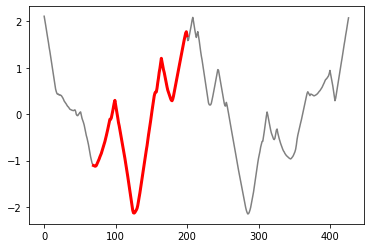

Series ID: 15, start_pos: 175, length: 14, info_gain: 0.2491642553233131, 


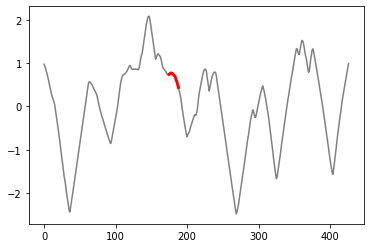

Series ID: 50, start_pos: 96, length: 98, info_gain: 0.10822901925374273, 


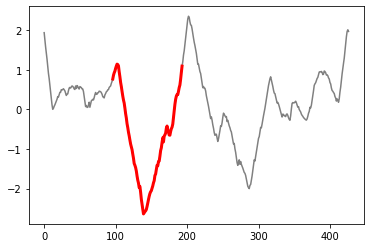

Series ID: 67, start_pos: 115, length: 164, info_gain: 0.06027262133059108, 


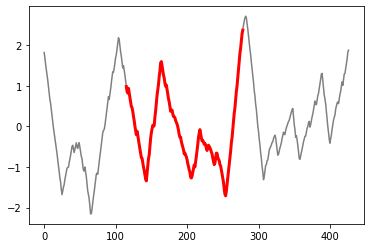

Series ID: 15, start_pos: 395, length: 20, info_gain: 0.05992553071341988, 


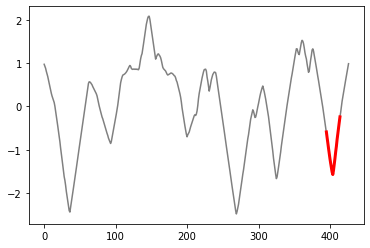

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

# for each extracted shapelet (in descending order of quality/information gain)
for s in st.shapelets[0:5]:

    # summary info about the shapelet
    print(s)

    # plot the series that the shapelet was extracted from
    plt.plot(train_x.iloc[s.series_id, 0], "gray")

    # overlay the shapelet onto the full series
    plt.plot(
        list(range(s.start_pos, (s.start_pos + s.length))),
        train_x.iloc[s.series_id, 0][s.start_pos : s.start_pos + s.length],
        "r",
        linewidth=3.0,
    )
    plt.show()

#0: Series ID: 77, start_pos: 69, length: 132, info_gain: 0.3007372162534431, 
#1: Series ID: 15, start_pos: 175, length: 14, info_gain: 0.2491642553233131, 
#2: Series ID: 50, start_pos: 96, length: 98, info_gain: 0.10822901925374273, 
#3: Series ID: 67, start_pos: 115, length: 164, info_gain: 0.06027262133059108, 
#4: Series ID: 15, start_pos: 395, length: 20, info_gain: 0.05992553071341988, 


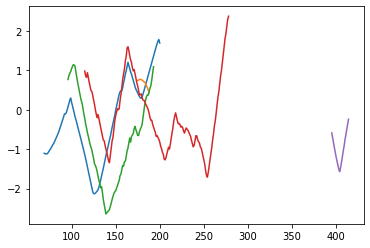

In [4]:
# for each extracted shapelet (in descending order of quality/information gain)
for i in range(0, min(len(st.shapelets), 5)):
    s = st.shapelets[i]
    # summary info about the shapelet
    print("#" + str(i) + ": " + str(s))

    # overlay shapelets
    plt.plot(
        list(range(s.start_pos, (s.start_pos + s.length))),
        train_x.iloc[s.series_id, 0][s.start_pos : s.start_pos + s.length],
    )

plt.show()

In [5]:
# takes a few minutes to run
import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

from sktime.datasets import load_osuleaf

train_x, train_y = load_osuleaf(split="train", return_X_y=True)
test_x, test_y = load_osuleaf(split="test", return_X_y=True)

# example pipeline with 1 minute time limit
pipeline = Pipeline(
    [
        (
            "st",
            ContractedShapeletTransform(
                time_contract_in_mins=time_contract_in_mins,
                num_candidates_to_sample_per_case=10,
                verbose=False,
            ),
        ),
        ("rf", RandomForestClassifier(n_estimators=100)),
    ]
)

start = time.time()
pipeline.fit(train_x, train_y)
end_build = time.time()
preds = pipeline.predict(test_x)
end_test = time.time()

print("Results:")
print("Correct:")
correct = sum(preds == test_y)
print("\t" + str(correct) + "/" + str(len(test_y)))
print("\t" + str(correct / len(test_y)))
print("\nTiming:")
print("\tTo build:   " + str(end_build - start) + " secs")
print("\tTo predict: " + str(end_test - end_build) + " secs")

3.982065439224243
6.5355384349823
7.831435441970825
10.228036880493164
11.709542751312256
Results:
Correct:
	137/242
	0.5661157024793388

Timing:
	To build:   286.73444390296936 secs
	To predict: 52.10409212112427 secs


# Evaluate the Results

In [6]:
from sklearn.metrics import classification_report, confusion_matrix

In [7]:
print( confusion_matrix(test_y, preds) )
print(classification_report(test_y, preds))

[[26  0  0  0  4  2]
 [ 1 15  0 30  5  4]
 [ 1  2 29  2  5  3]
 [ 0  6  0 36  2  0]
 [ 3  1 10  3 28  1]
 [ 5  4  2  3  6  3]]
              precision    recall  f1-score   support

           1       0.72      0.81      0.76        32
           2       0.54      0.27      0.36        55
           3       0.71      0.69      0.70        42
           4       0.49      0.82      0.61        44
           5       0.56      0.61      0.58        46
           6       0.23      0.13      0.17        23

    accuracy                           0.57       242
   macro avg       0.54      0.56      0.53       242
weighted avg       0.56      0.57      0.54       242

